## Ideas

* convolutional neural network: build a network that loads an image into memory, takes 28x28 patches, applies a transform of some kind, and then runs it through a CNN with clean versions of the same transformed patch as the ground-truth output. 
* texture is sparse in a basis: can use the image as a measurement matrix; rows where there is no text will give clear measurements of the pattern. assume structure is low-rank; use geophysics rotation trick to cover missing rows? 
* besov space, TV denoising. 



## packages

In [1]:
import numpy as np

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import scipy as sp

In [3]:
from glob import glob
from datetime import date
import feather
import imageio

In [4]:
plt.rcParams['font.size'] = 16

## Load Data

In [5]:
train_dir = './data/train/'
train_cleaned_dir = './data/train_cleaned/'
test_dir = './data/test/'

In [6]:
def loadFormattedImg(file_path):
    img = imageio.imread(file_path)
    img = img.astype(float) / 255
    return img

def loadImgDict(data_dir, img_type='png'):
    file_names = glob(data_dir + '*.' + img_type)
    return {fn.split('/')[-1].split('.')[0] : loadFormattedImg(fn) for fn in file_names}

In [7]:
train_dirty = loadImgDict(train_dir)
train_clean = loadImgDict(train_cleaned_dir)
test = loadImgDict(test_dir)

In [8]:
def plotImgPair(dirty, clean, titles=['dirty', 'clean']):
    plt.subplot(121)
    plt.imshow(dirty, cmap=plt.cm.binary_r)
    plt.title(titles[0])
    plt.subplot(122)
    plt.imshow(clean, cmap=plt.cm.binary_r)
    plt.title(titles[1])
    return

## Data Exploration
### View an imported image

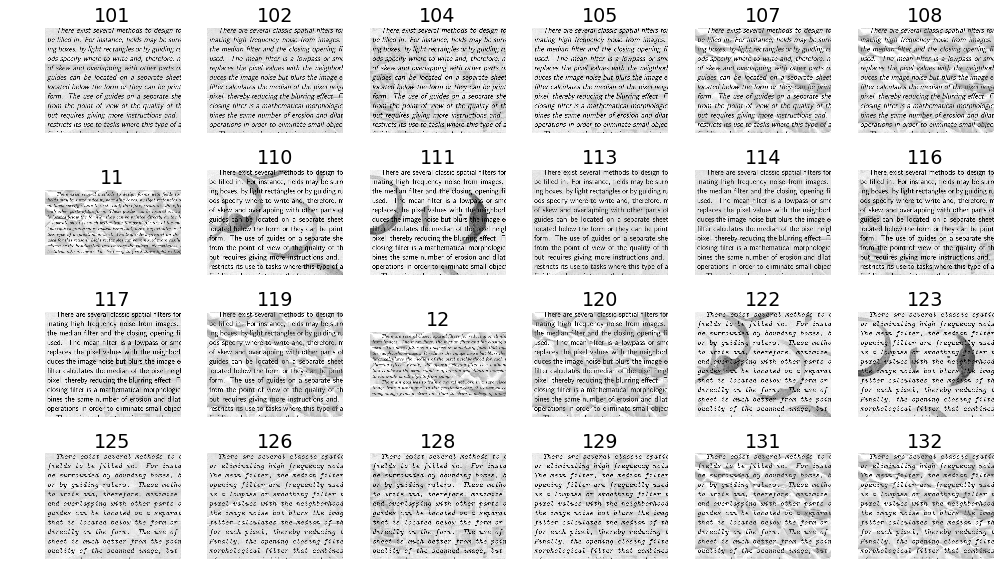

In [9]:
plt.figure(figsize=(17,10))
for j, (k, v) in enumerate(sorted(train_dirty.items())):
    plt.subplot(4,6,j+1)
    plt.imshow(v, cmap=plt.cm.binary_r)
    plt.title(k);
    plt.axis('off');
    if j+2 > 4*6:
        break

In [10]:
trdkey = sorted(train_dirty.keys())
trckey = sorted(train_clean.keys())

In [11]:
img0 = train_dirty[trdkey[0]]
img0c = train_clean[trdkey[0]]

img1 = train_dirty['111']
img1c = train_clean['111']

img0.shape

(420, 540)

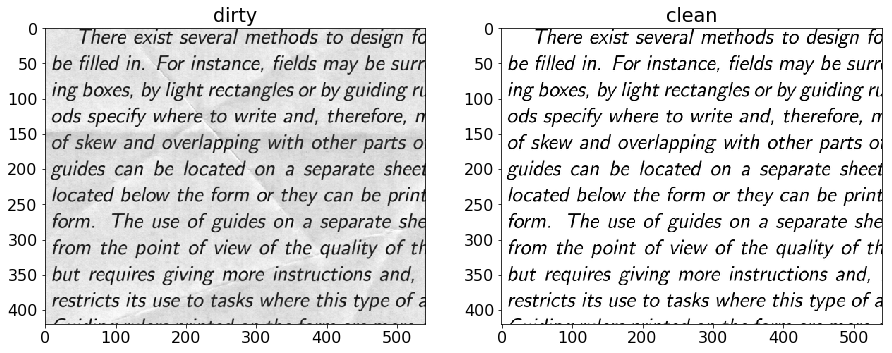

In [12]:
plt.figure(figsize=(15,8))
plotImgPair(img0, img0c)

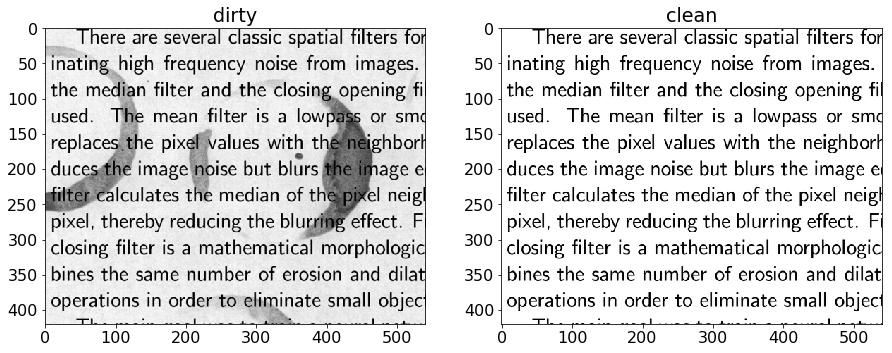

In [13]:
plt.figure(figsize=(15,8))
plotImgPair(img1, img1c)

### Evaluation

In [14]:
from sklearn.metrics import mean_squared_error

In [15]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [16]:
def rmseRatio(y_true, y_nois, y_pred):
    return rmse(y_true, y_nois) / rmse(y_true, y_pred)

### Uploading Results

In [17]:
def convertToUpload(key, img):
    idcol = np.array([['{}_{}_{}'.format(key,j+1,k+1) 
                       for k in range(img.shape[1])] 
                      for j in range(img.shape[0])]).ravel()
    valcol = img.ravel()
    return pd.DataFrame(np.column_stack((idcol, valcol)), columns=['id', 'value'])

In [18]:
def saveSubmission(imgDict, path_or_buf=None, **kwargs):
    if path_or_buf is None:
        path_or_buf = './data/submissions/kaggle_submission_{}.csv'.format(date.today().isoformat())
    subm = pd.concat([convertToUpload(*i) for i in imgDict.items()])
    subm.to_csv(path_or_buf=path_or_buf, index=False, **kwargs)
    return

### Linear estimates

Text(0,0.5,'cleaned')

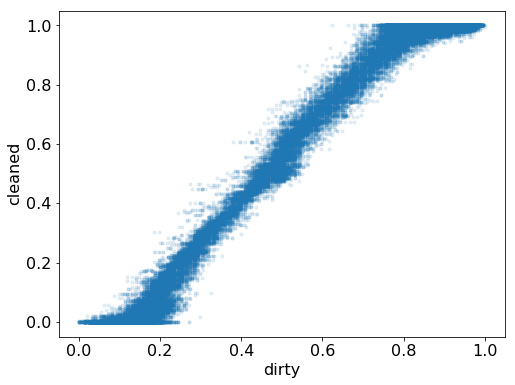

In [19]:
plt.figure(figsize=(8,6))
plt.plot(img0.ravel(), img0c.ravel(), '.', alpha=.1);
plt.xlabel('dirty')
plt.ylabel('cleaned')

In [20]:
from sklearn.linear_model import LinearRegression, ElasticNetCV

In [21]:
linr = LinearRegression(normalize=True)
enet = ElasticNetCV()

In [22]:
linr.fit(img0.reshape(-1,1), img0c.ravel())
img0_lin = linr.predict(img0.reshape(-1,1)).reshape(img0.shape)

enet.fit(img0.reshape(-1,1), img0c.ravel())
img0_enet = enet.predict(img0.reshape(-1,1)).reshape(img0.shape)

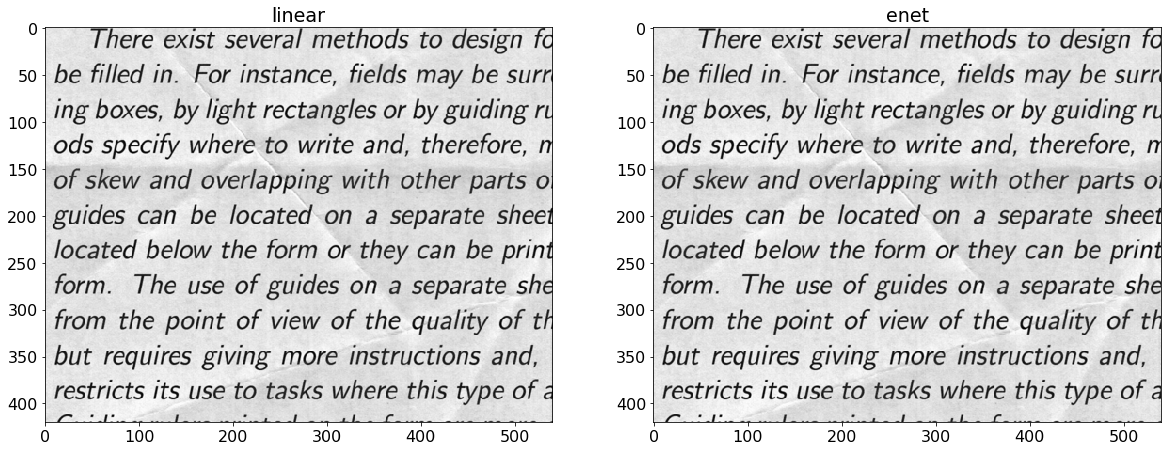

In [23]:
plt.figure(figsize=(20,10))
plotImgPair(img0_lin, img0_enet, titles=['linear', 'enet'])

In [24]:
rmseRatio(img0c, img0, img0_lin)

2.5116597412574806

In [25]:
rmseRatio(img0c, img0, img0_enet)

2.5113844710102353

### Hard Thresholding by histogram

In [26]:
from sklearn.neighbors import KernelDensity
from sklearn.cluster import KMeans

In [27]:
km = KMeans(n_clusters=3, n_jobs=-1)

In [28]:
km.fit(img0.reshape(-1,1))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

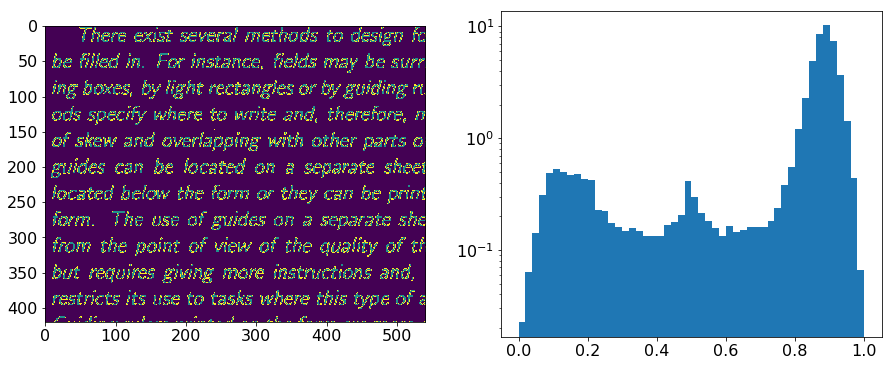

In [29]:
plt.figure(figsize=(15,6))
plt.subplot(121)
plt.imshow(km.predict(img0.reshape(-1,1)).reshape(img0.shape));
plt.subplot(122)
plt.hist(img0.ravel(), bins=50, log=True, density=True);

The goal of this empirical hard-thresholding is to find the second valley in the histogram above — that will be the value that we threshold by. This computation is performed by `bestThreshold`. The actual hardthreshold is then done by `hardThreshold`: any values above the threshold value will be set to 1. 

In [30]:
def bestThreshold(data):
    km = KMeans(n_clusters=3, n_jobs=-1)
    km.fit(data.reshape(-1,1))
    
    unit = np.linspace(0, 1, 1001)
    y = km.predict(unit.reshape(-1,1))
    chgpts = np.where(np.abs(np.diff(y)) > 0)[0]
    return .5 * (unit[chgpts.max()] + unit[chgpts.max()+1])

In [31]:
def hardThreshold(img, lam, vmin=0, vmax=1):
    imgTh = img.copy()
    imgTh[imgTh > lam] = vmax
    return imgTh

In [32]:
def multiThreshold(img, imgc, lam_vec):
    rmse_vec = np.array([rmse(imgc, hardThreshold(img, lam)) for lam in lam_vec])
    return rmse_vec

In [33]:
lam_vec = np.linspace(0, 1, 1001)
rmse0_vec = multiThreshold(img0, img0c, lam_vec)

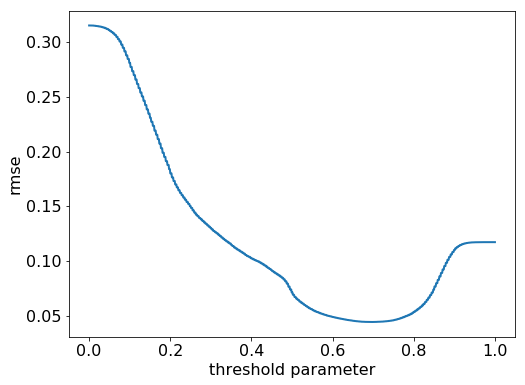

In [34]:
plt.figure(figsize=(8,6))
plt.plot(lam_vec, rmse0_vec, linewidth=2)
plt.xlabel('threshold parameter')
plt.ylabel('rmse');

In [35]:
singleLine = img0[10,:]
singleLinec = img0c[10,:]
singleLineTh = hardThreshold(singleLine, bestThreshold(singleLine))

Text(0,0.5,'clean')

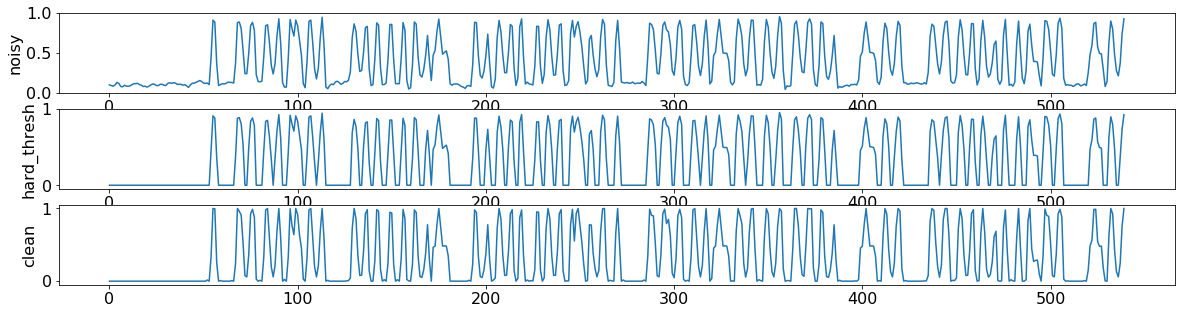

In [36]:
plt.figure(figsize=(20,5))
plt.subplot(311)
plt.plot(1-singleLine)
plt.ylabel('noisy', size=16)
plt.subplot(312)
plt.plot(1- singleLineTh)
plt.ylabel('hard_thresh', size=16)
plt.subplot(313)
plt.plot(1-singleLinec)
plt.ylabel('clean', size=16)

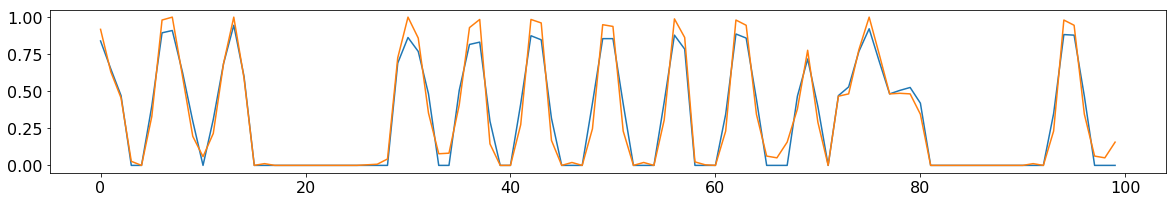

In [37]:
plt.figure(figsize=(20,3))
plt.plot(1- singleLineTh[100:200])
plt.plot(1-singleLinec[100:200]);

In [38]:
img0Th = hardThreshold(img0, bestThreshold(img0))

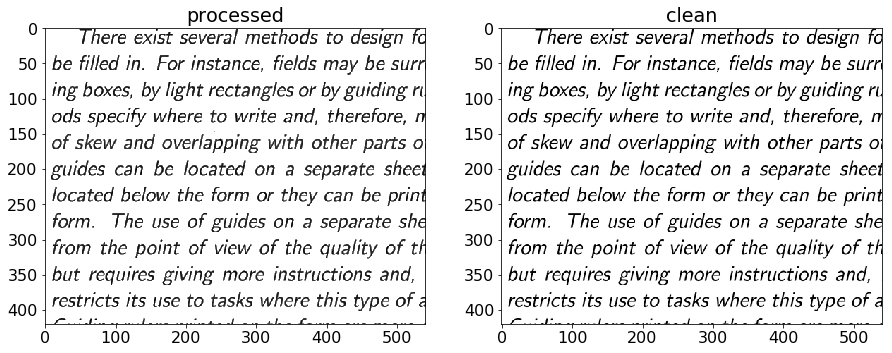

In [39]:
plt.figure(figsize=(15,6))
plotImgPair(img0Th, img0c, ['processed', 'clean'])

Already this looks pretty good on this image. It's pretty hard to tell the difference between the processed image and the clean image. 

### Evaluation

The contest evaluates by root mean-squared error, so shall we too.

In [40]:
rmse(img0c, img0Th)

0.044136217383978764

In [41]:
rmseRatio(img0c, img0, img0Th)

2.6532441954226376

#### Make a submission!

So it looks like hard thresholding does 2.5 times better already. Maybe that's good enough to make a submission!

In [42]:
test_clean = {k: hardThreshold(v, bestThreshold(v)) for k,v in test.items()}
saveSubmission(test_clean, './data/submissions/empirThresholding_submn_{}.csv'.format(date.today().isoformat()))

It could certainly do better:

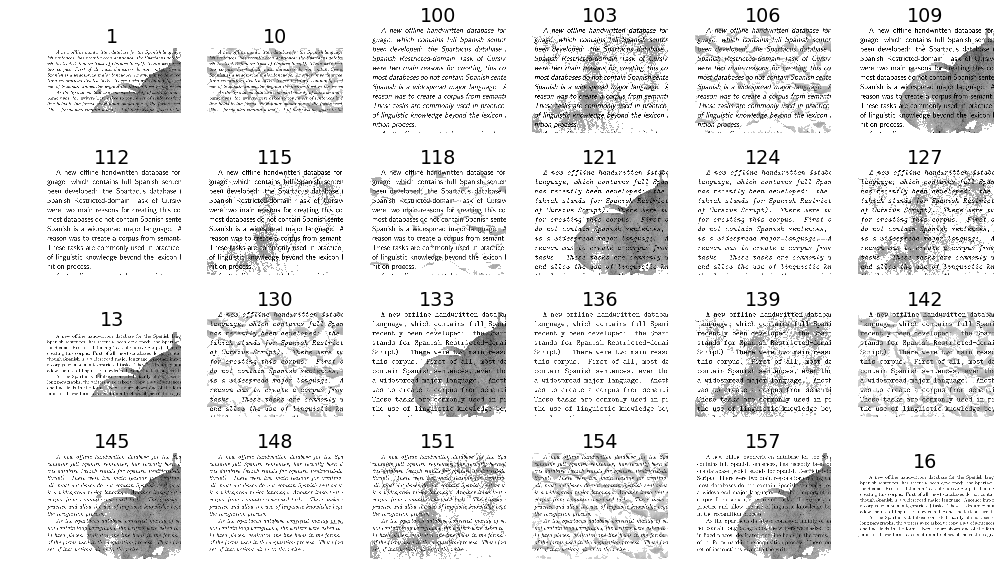

In [43]:
plt.figure(figsize=(17,10))
for j, (k, v) in enumerate(sorted(test_clean.items())):
    plt.subplot(4,6,j+1)
    plt.imshow(v, cmap=plt.cm.binary_r)
    plt.title(k);
    plt.axis('off');
    if j+2 > 4*6:
        break

### With Wavelets

In [44]:
import pywt

In [45]:
print(pywt.families())
print(pywt.wavelist('db')[:10])

['haar', 'db', 'sym', 'coif', 'bior', 'rbio', 'dmey', 'gaus', 'mexh', 'morl', 'cgau', 'shan', 'fbsp', 'cmor']
['db1', 'db2', 'db3', 'db4', 'db5', 'db6', 'db7', 'db8', 'db9', 'db10']


In [46]:
wimg0 = pywt.wavedec2(img0, 'db2')

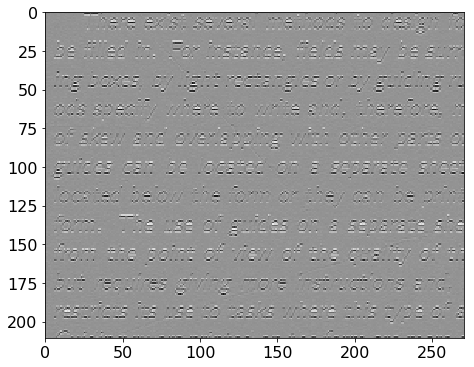

In [47]:
plt.figure(figsize=(8,6))
plt.imshow(wimg0[-1][0], cmap=plt.cm.binary_r)

#### Build a Besove Space denoiser

Goal: take in the wavelet coefficients and return a soft-thresholded version. Note that this should be able to cascasde. 

Future goal: implement multi-scale de-noising

In [48]:
wimg0_arr = pywt.coeffs_to_array(wimg0)
wimg0_flat = wimg0_arr[0]

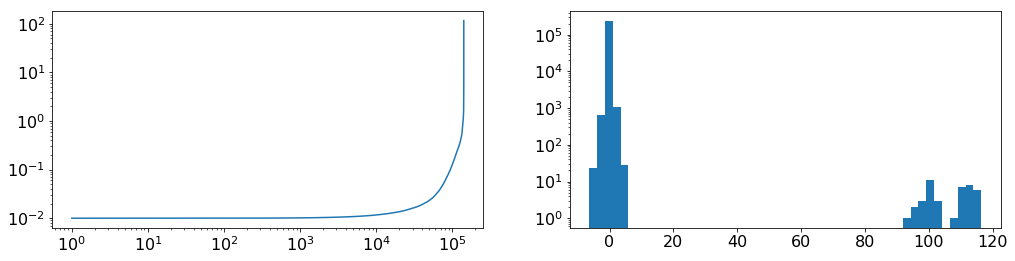

In [50]:
plt.figure(figsize=(17,4))
plt.subplot(121)
plt.plot(sorted(np.abs(wimg0_flat.ravel())[np.abs(wimg0_flat.ravel()) > 1e-2]))
plt.xscale('log')
plt.yscale('log')
plt.subplot(122)
plt.hist(wimg0_flat.ravel(), bins=50, log=True);

/Users/aberk/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


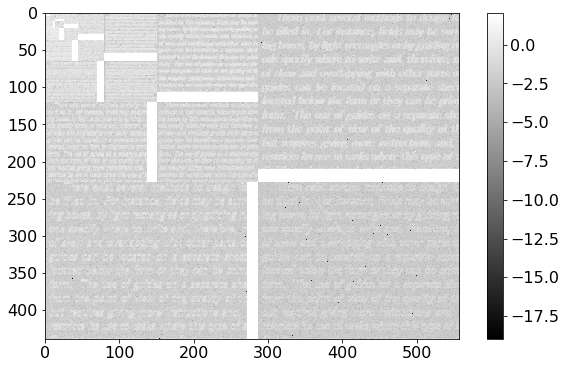

In [51]:
plt.figure(figsize=(10,6))
plt.imshow(np.log10(np.abs(wimg0_arr[0])), cmap=plt.cm.binary_r)
plt.colorbar();

### Engineer's Image Processing

#### 1D filter

cf [StackOverflow](https://stackoverflow.com/a/25192640/1456421) for linear 1d filter implementation and intuition.

In [44]:
from scipy.signal import butter, lfilter, freqz

In [ ]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = .5 * fs
    normal_cutoff = cutoff / nyq
    b,a = butter(order, normal_cutoff, btype='low', analog=False)
    return b,a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

#### Image filter

In [45]:
from scipy import ndimage

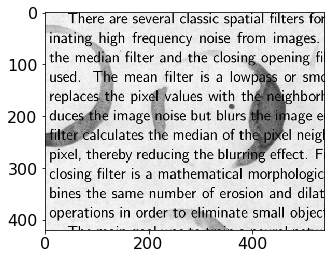

In [83]:
lowpass = ndimage.gaussian_filter(img1, .1, order=0)
plt.imshow(lowpass, plt.cm.binary_r);

Good for abstract art:

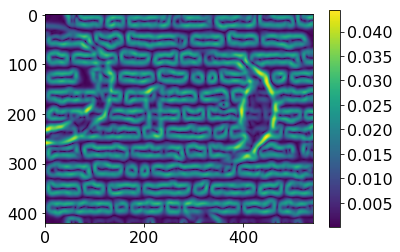

In [82]:
plt.imshow(ndimage.filters.gaussian_gradient_magnitude(img1, 5));
plt.colorbar()

#### Fourier transform

In [121]:
Fimg0 = np.fft.fft2(img0)

In [122]:
Fimg0c = np.fft.fft2(img0c)

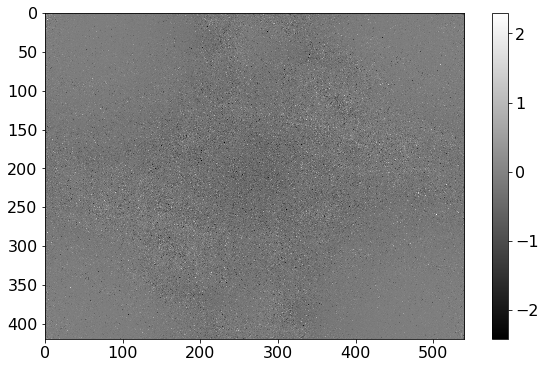

In [125]:
plt.figure(figsize=(10,6))
plt.imshow(np.log10(np.abs(Fimg0)) - np.log10(np.abs(Fimg0c)), cmap=plt.cm.binary_r)
plt.colorbar();

### Median Filtering for Background removal

In [85]:
from scipy import signal as sg

In [93]:
img0_med = sg.medfilt2d(np.pad(img0, 12, 'edge'), kernel_size=21)
img0_med = img0_med[12:-12, 12:-12]

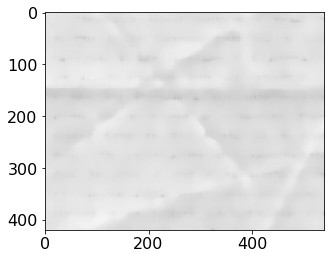

In [96]:
plt.imshow(img0_med, vmax=1, vmin=0, cmap=plt.cm.binary_r)